# Features selection 

In [1]:
from datetime import datetime, timedelta

import numpy as np
print('Numpy version: ', np.__version__)
import pandas as pd
print('Pandas version: ', pd.__version__)
import matplotlib as mpl
from matplotlib import pyplot as plt
print('Matplotlib version: ', mpl.__version__)
import seaborn as sns
print('Seaborn version: ', sns.__version__)

import sklearn as skl
print('Scikit-learn version: ', skl.__version__)

from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold, SelectFromModel, RFECV # recursive feature elimination
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

import feature_engine as fe

from tqdm import tqdm

import pipeline_classes as plc

import scipy
print('Scipy version:', scipy.__version__)
import scipy.stats as stats

import statsmodels as sm
print('Statsmodels version:', sm.__version__)
import statsmodels.api as sma
#from mlxtend.feature_selection import SequentialFeatureSelector

Numpy version:  1.23.5
Pandas version:  1.5.2
Matplotlib version:  3.6.2
Seaborn version:  0.12.1
Scikit-learn version:  1.1.3
Scipy version: 1.9.3
Statsmodels version: 0.13.5


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('datasets/processed/train_floats_as_df.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 242 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(242)
memory usage: 2.7 MB


In [4]:
y = pd.read_csv('datasets/train.csv', index_col=0)['SalePrice']

## 1. Additional correlation analysis after converting to num 

> ### !!! Have to try to convert categorical columns not with one-hot principle but using frequence or mean target value for each category.

Here are results of detailed correlation analysis:

High negative correlations:  
(1) Columns 'AgeBuilt', 'AgeRemodeled' and 'AgeGarage' have correlation coefficient -1.0 with correspondent 'Year*' features as they calculated using them. I've simply forgot to delete it  
(2) 'GarageType_Abs' has high negative correlation with 'GarageQual' and 'GarageCond' and high positive correlation with 'AgeGarage'. As all these 4 features have strong correlation with each other we can drop 3 of them and leave the only one. Let it be 'GarageCond' as the overall indicator of current condition of the garage  
(3) Columns 'YrSold' and 'MoSold' should be dropped as well  
(4) As 'CentralAir' column didn't contain any NANs and have only 2 options (Y|N) we can drop on of them (let it be N for clarity)  
(5) 'MiscFeature_Abs' should be dropped too as it contains only info about absence of other features  
(6) We can drop all the columns transformed to one-hot form if their sum() == 0 as they doesn't contain any info for model. For those columns we can exclude correspondent categories from initial transformation pipeline (optional for future)  
(7) DO NOT TOUCH FOR NOW 'RoofStyle_Gable' and 'RoofStyle_Hip'. CHECK THEM FOR LOW VARIANCE!!!  
(8) 'MasVnrType_None' has strong negative correlation with 'MasVnrType_BrkFace'. Delete the first as it contains only info about absence  
(9) Check 'Electrical_SBrkr' and 'Electrical_FuseA' for low variance (-0.86 correlation)  
(10) Same for 'MSZoning_RL', 'MSZoning_RM' (-0.8 correlation)  
(11) We can safely drop 'Alley_Abs'  
(12) Check 'LotConfig_Inside' and 'LotConfig_Corner' for low variance (-0.75 correlation)  
(13) 'SaleCondition_Partial' has enormous correlation with 'SaleType_New' (~0.99) and high with 'SaleType_WD' (-0.77); 'SaleType_New' and 'SaleType_WD' - high correlation -0.77. Delete 'SaleType_New' as all records where its value is 1.0 are with 1.0 in 'SaleCondition_Partial' (122 records 'SaleType_New' vs 125 recs 'SaleCondition_Partial')

High positive correlations:  
(1) 'PoolQC' and 'PoolArea' (0.93). Drop 'PoolQC' as it's categorical (less objective) info  
(2) 'MSSubClass_45' and 'HouseStyle_1.5Unf' (0.93). Drop 'MSSubClass_45' as all records where its value is 1.0 have 1.0 in 'HouseStyle_1.5Unf' (12 records 'MSSubClass_45' vs 14 recs 'HouseStyle_1.5Unf')  
(3) 'MSSubClass_50' and 'HouseStyle_1.5Fin' (0.94). Drop 'MSSubClass_50' as 141 of 144 recs have 1.0 in 'HouseStyle_1.5Fin' (154 recs)  
(4) 'MSSubClass_80' and 'HouseStyle_SLvl' (0.94). Drop 'MSSubClass_80' as all 58 recs have 1.0 in 'HouseStyle_SLvl' (65 recs)  
(5) 'MSSubClass_90' and 'BldgType_Duplex' (1.00). Drop 'MSSubClass_90' as both columns duplicate each other (52 recs)  
(6) 'MSSubClass_190' and 'BldgType_2fmCon' (0.98). Drop 'MSSubClass_190' as all 30 recs have 1.0 in 'BldgType_2fmCon' (31 recs)  
  
Correlations 0.8 < x < 0.9:  
(7) 'TotalBsmtSF' and '1stFlrSF' (0.82)  
(8) 'HouseStyle_2Story' and '2ndFlrSF' (0.81)  
(9) GrLivArea and TotRmsAbvGrd (0.83)  
(10) Fireplaces and FireplaceQu (0.86)  
(11) GarageCars and GarageArea (0.88)  
(12) MiscFeature_Gar2 and MiscVal (0.89)  
(13) MSZoning_FV and Neighborhood_Somerst (0.86)  
(14) RoofStyle_Flat and RoofMatl_Tar&Grv (0.84)  

We should also drop columns with all zeros. As dataset contains no negative values we can apply sum function to get what we want

In [5]:
col_sums = df.apply(sum, axis=0)
list(col_sums[col_sums == 0].index)

['PreCast',
 'MSSubClass_Abs',
 'MSSubClass_150',
 'MSZoning_Abs',
 'MSZoning_A',
 'MSZoning_I',
 'MSZoning_RP',
 'LandContour_Abs',
 'LotConfig_Abs',
 'Neighborhood_Abs',
 'BldgType_Abs',
 'HouseStyle_Abs',
 'RoofStyle_Abs',
 'RoofMatl_Abs',
 'MasVnrType_CBlock',
 'Foundation_Abs',
 'Heating_Abs',
 'CentralAir_Abs',
 'Electrical_Abs',
 'MiscFeature_Elev',
 'SaleType_Abs',
 'SaleType_VWD',
 'SaleCondition_Abs']

In [6]:
mcorr = df.corr()

<AxesSubplot: >

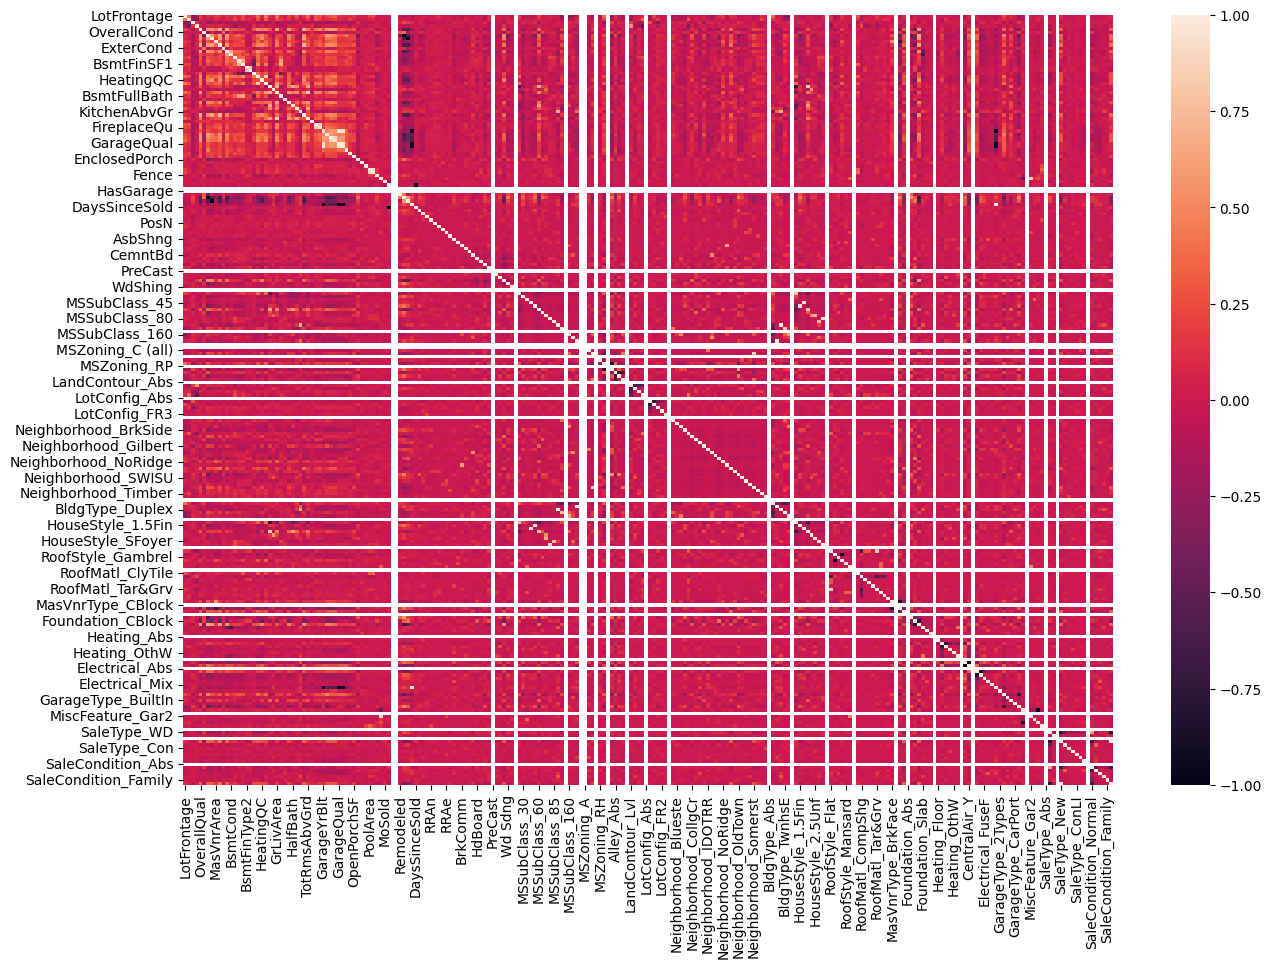

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(data=mcorr, ax=ax)

`mcorr` contains too much features and thus is difficult to analyze. We create 2 series containing maximum and minimum values of correlation coeff along columns/rows which will be used for filtering mcorr entries based on value passed  
As the main diagonal contains self-correlation values which is always 1.0 we have to exclude each column's name when applying _max()_ function to corresponding row

In [8]:
mcorr_maxs = mcorr.apply(lambda x: x.drop(labels=x.name).max(), axis=1) # drop excludes the column/row itself from determining max value
mcorr_mins = mcorr.apply(min, axis=1) # there's no need to additionally modify scoupe of min search

In [9]:
# exclude_... variables contain column names which we have analyzed already and thus they have to be filtered out
# results of analysis are shown right after this part's header
exclude_neg_corr_list = ['MSZoning_RL', 'MSZoning_RM', 'RoofStyle_Gable', 'RoofStyle_Hip', 'Electrical_SBrkr', 'Electrical_FuseA', 'LotConfig_Inside', 'LotConfig_Corner']
exclude_pos_corr_list = []
thresh = 0.8
m = ((mcorr_maxs > thresh) & (~mcorr_maxs.index.isin(exclude_pos_corr_list))) # creating mask 
pd.concat([mcorr.loc[m, m], mcorr_maxs[m]], keys=['main', 'max_values'], axis=1)

main                                             \
                      TotalBsmtSF  1stFlrSF  2ndFlrSF GrLivArea TotRmsAbvGrd   
TotalBsmtSF              1.000000  0.819530 -0.174512  0.454868     0.285573   
1stFlrSF                 0.819530  1.000000 -0.202646  0.566024     0.409516   
2ndFlrSF                -0.174512 -0.202646  1.000000  0.687501     0.616423   
GrLivArea                0.454868  0.566024  0.687501  1.000000     0.825489   
TotRmsAbvGrd             0.285573  0.409516  0.616423  0.825489     1.000000   
Fireplaces               0.339519  0.410531  0.194561  0.461679     0.326114   
FireplaceQu              0.347615  0.407887  0.207129  0.469947     0.355589   
GarageYrBlt              0.176359  0.166642  0.064402  0.162543     0.095607   
GarageCars               0.434585  0.439317  0.183926  0.467247     0.362289   
GarageArea               0.486665  0.489782  0.138347  0.468997     0.337822   
GarageQual               0.173183  0.176630  0.056682  0.166432     0.091251   
GarageCond               0.176578  0.171546  0.046886  0.153327     0.080547   
PoolArea                 0.126053  0.131525  0.081487  0.170205     0.083757   
PoolQC                   0.161273  0.155367  0.100361  0.206441     0.091779   
MiscVal                 -0.018479 -0.021096  0.016197 -0.002416     0.024763   
AgeGarage               -0.176359 -0.166642 -0.064402 -0.162543    -0.095607   
MSSubClass_45           -0.052866 -0.067342 -0.072387 -0.110689    -0.099045   
MSSubClass_50           -0.156082 -0.145729  0.144654  0.024674     0.028891   
MSSubClass_80           -0.062018  0.021140 -0.072909 -0.047277    -0.028128   
MSSubClass_90           -0.043368  0.081051 -0.046373  0.018967     0.138913   
MSSubClass_190          -0.070908 -0.044073  0.054868  0.018429     0.072698   
MSZoning_FV             -0.032689 -0.095486  0.114848  0.024275    -0.044264   
Neighborhood_Somerst     0.043137 -0.018495  0.064675  0.038667    -0.015275   
BldgType_2fmCon         -0.071094 -0.046158  0.050217  0.012894     0.064178   
BldgType_Duplex         -0.043368  0.081051 -0.046373  0.018967     0.138913   
HouseStyle_1.5Fin       -0.164859 -0.139340  0.145911  0.032348     0.041523   
HouseStyle_1.5Unf       -0.051732 -0.067778 -0.078241 -0.115954    -0.109217   
HouseStyle_2Story       -0.178810 -0.269813  0.809150  0.468836     0.430930   
HouseStyle_SLvl         -0.079888  0.013150 -0.078799 -0.058188    -0.038133   
RoofStyle_Flat           0.012210  0.062484 -0.033482  0.017100    -0.039181   
RoofMatl_Tar&Grv         0.000420  0.071021 -0.023777  0.031528    -0.013142   
GarageType_Abs          -0.160098 -0.154846 -0.060821 -0.151015    -0.088285   
MiscFeature_Gar2         0.008620 -0.000300  0.023977  0.019286     0.045183   
SaleType_New             0.265644  0.221219  0.010810  0.168368     0.147496   
SaleCondition_Partial    0.266268  0.221037  0.004852  0.163239     0.142032   

                                                                     \
                      Fireplaces FireplaceQu GarageYrBlt GarageCars   
TotalBsmtSF             0.339519    0.347615    0.176359   0.434585   
1stFlrSF                0.410531    0.407887    0.166642   0.439317   
2ndFlrSF                0.194561    0.207129    0.064402   0.183926   
GrLivArea               0.461679    0.469947    0.162543   0.467247   
TotRmsAbvGrd            0.326114    0.355589    0.095607   0.362289   
Fireplaces              1.000000    0.863241    0.186264   0.300789   
FireplaceQu             0.863241    1.000000    0.206738   0.370034   
GarageYrBlt             0.186264    0.206738    1.000000   0.598005   
GarageCars              0.300789    0.370034    0.598005   1.000000   
GarageArea              0.269141    0.327973    0.560783   0.882475   
GarageQual              0.208556    0.221797    0.946629   0.576622   
GarageCond              0.198003    0.210507    0.949411   0.568408   
PoolArea                0.095074    0.048737    0.015858   0.020934   
Poo

In [10]:
# determining of how much overlap one-hot encoded values
vals = ['MSSubClass_190', 'BldgType_2fmCon']
for val in vals:
    print(f'records with {val}:', df[val].sum())

records with MSSubClass_190: 30.0
records with BldgType_2fmCon: 31.0


In [11]:
df[(df['MSSubClass_190'] == 1.0) & (df['BldgType_2fmCon'] == 1.0)]

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Abs,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
10,50.0,7420.0,4.0,3.0,5.0,6.0,1939.0,1950.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
49,33.0,4456.0,4.0,3.0,4.0,5.0,1920.0,2008.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
94,60.0,7200.0,4.0,3.0,6.0,6.0,1910.0,1998.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
126,60.0,6780.0,4.0,3.0,6.0,8.0,1935.0,1982.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
166,62.0,10106.0,4.0,3.0,5.0,7.0,1940.0,1999.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
247,69.0,9142.0,4.0,3.0,6.0,8.0,1910.0,1950.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
292,55.0,5687.0,4.0,3.0,5.0,6.0,1912.0,2000.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
301,90.0,15750.0,4.0,3.0,5.0,5.0,1953.0,1953.0,56.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
313,65.0,7800.0,4.0,3.0,5.0,7.0,1939.0,1950.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: xlabel='TotalBsmtSF', ylabel='Count'>

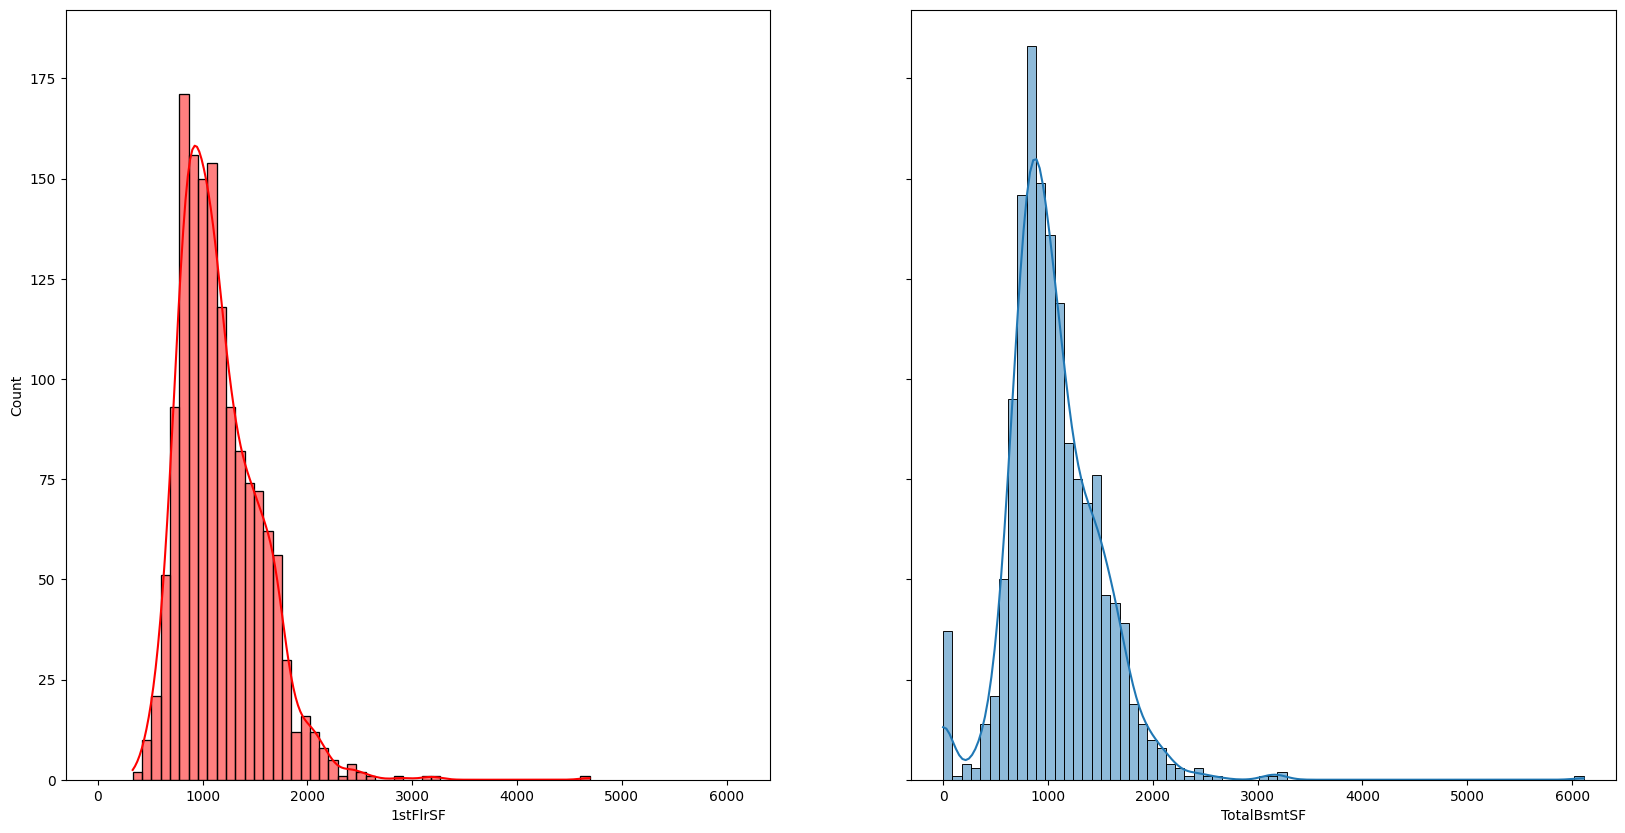

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
sns.histplot(data=df, x='1stFlrSF', ax=ax[0], color='red', kde=True)
sns.histplot(data=df, x='TotalBsmtSF', ax=ax[1], kde=True)
#sns.histplot(data=df, x='TotalBsmtSF', y='1stFlrSF', ax=ax)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-2.41116693, -2.41116693, -2.41116693, ...,  4.88552238,
          4.89920368, 11.52094923])),
 (0.9583630454940711, 4.607218348968633e-16, 0.9564534567679281))

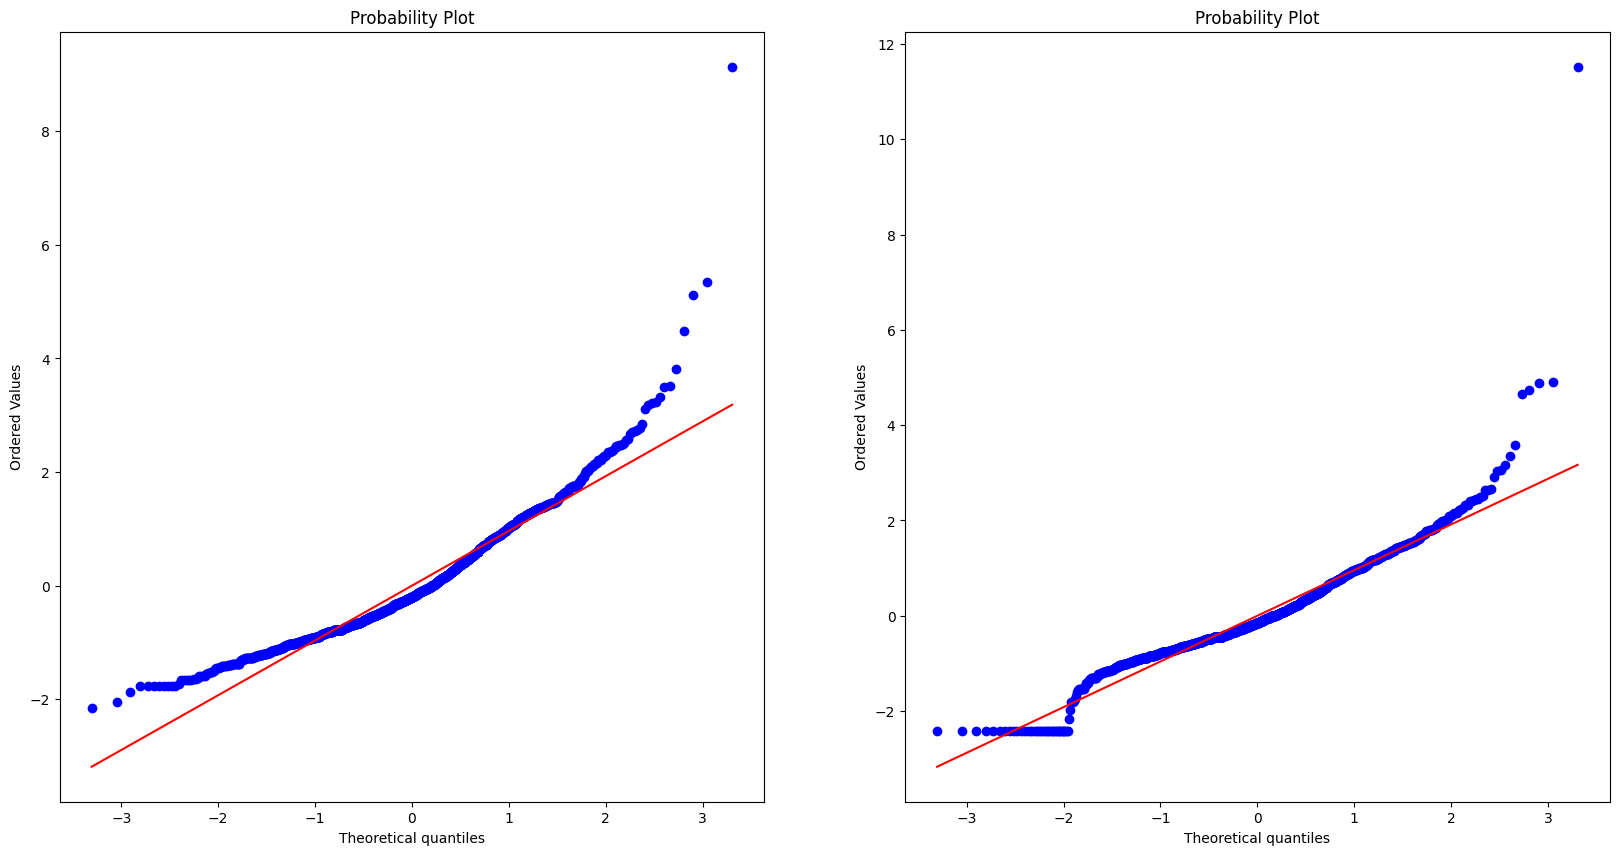

In [13]:
# checking "normality" comparing fact vs theoretical distribution
vals_1stFlrSF = df['1stFlrSF']
vals_TotalBsmtSF = df['TotalBsmtSF']
z1 = (vals_1stFlrSF-np.mean(vals_1stFlrSF))/np.std(vals_1stFlrSF)
z2 = (vals_TotalBsmtSF-np.mean(vals_TotalBsmtSF))/np.std(vals_TotalBsmtSF)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
stats.probplot(z1, dist="norm", plot=ax[0])
stats.probplot(z2, dist="norm", plot=ax[1])


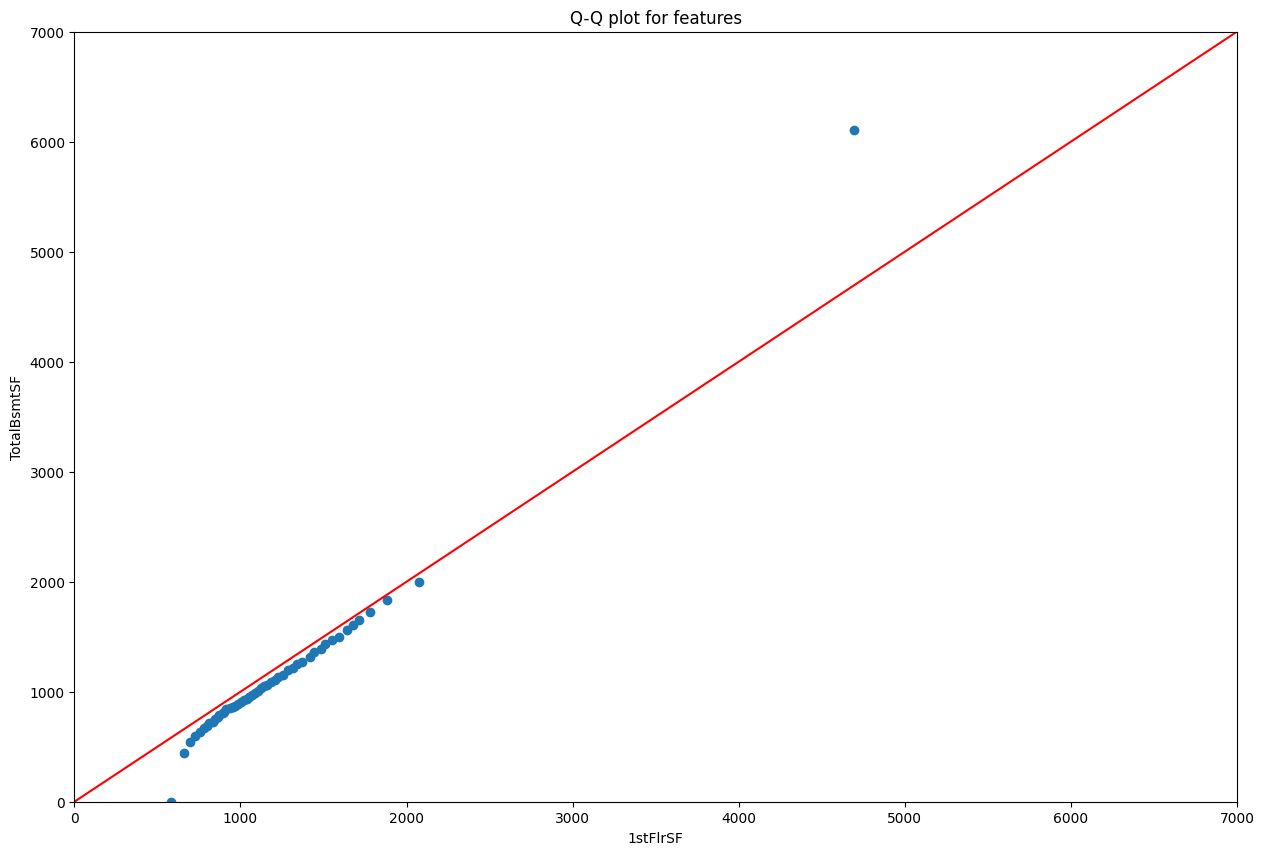

In [14]:
quantiles1 = []
quantiles2 = []
for q in range(2, 101, 2):
    quantiles1.append(vals_1stFlrSF.quantile(q=float(q)/100.0))
    quantiles2.append(vals_TotalBsmtSF.quantile(q=float(q)/100.0))

upper_xy = (int(max(max(quantiles1), max(quantiles2))/1000)+1)*1000
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.scatter(x=quantiles1, y=quantiles2)
plt.plot([0, upper_xy], [0, upper_xy], c='red')
ax.set_xbound(lower=0, upper=upper_xy)
ax.set_ybound(lower=0, upper=upper_xy)
ax.set_xlabel('1stFlrSF')
ax.set_ylabel('TotalBsmtSF')
ax.set_title('Q-Q plot for features');

In [15]:
# Kholmogorov-Smirnov test to check whether the data given follows Normal (or any other) Distribution or not 
print(stats.kstest(z1, "norm"))
print(stats.kstest(z2, "norm"))

KstestResult(statistic=0.08691902539030016, pvalue=4.791029765120081e-10)
KstestResult(statistic=0.07593952292488682, pvalue=9.069791178246528e-08)


By default this is 2-sided test because initially we don't do any assumptions about distributions. As p-value in both cases is much lower than 0.05 (default significance level for hypotheses testing) we conclude that distributions are not normal

In [16]:
# what are outliers
df[(df['1stFlrSF'] > 3000.0) | (df['TotalBsmtSF'] > 3000.0)][['1stFlrSF', 'TotalBsmtSF', 'LotArea']]

,1stFlrSF,TotalBsmtSF,LotArea
Id,,,
333,1629.0,3206.0,10655.0
441,2402.0,3094.0,15431.0
497,3228.0,3200.0,12692.0
524,3138.0,3138.0,40094.0
1299,4692.0,6110.0,63887.0


Here we have final pipeline for cleaning out redundant features determined by analysis of correlations

In [17]:
extra_cleaning_pipeline = Pipeline([
    ('del_oh_zero_sum', plc.DFDropColumns(columns=list(col_sums[col_sums == 0].index))),
    ('del_year_feats', plc.DFDropColumns(
        columns=[
            'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'GarageType_Abs', 'GarageQual', 'AgeGarage', 'MoSold', 'YrSold', 'CentralAir_N', 'MiscFeature_Abs',
            'MasVnrType_None', 'Alley_Abs', 'SaleType_New', 'PoolQC', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_80', 'MSSubClass_90', 'MSSubClass_190'
        ]
    )),
])

In [18]:
df = extra_cleaning_pipeline.fit_transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 200 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(200)
memory usage: 2.2 MB


So we've get rid of 42 features.  
Let's continue with outliers detection and analysis

## 2. Detecting outliers

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 200 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(200)
memory usage: 2.2 MB


In [20]:
# Scaling features to get universal dataset for all outliers detection methods
scaler = MinMaxScaler()
x = scaler.fit_transform(df)
x = pd.DataFrame(x, columns=df.columns)
x

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,0.150685,0.033420,1.000000,1.0,0.666667,0.500,0.122500,0.666667,0.50,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.202055,0.038795,1.000000,1.0,0.555556,0.875,0.000000,0.333333,0.50,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.160959,0.046507,0.666667,1.0,0.666667,0.500,0.101250,0.666667,0.50,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.133562,0.038561,0.666667,1.0,0.666667,0.500,0.000000,0.333333,0.50,0.6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.215753,0.060576,0.666667,1.0,0.777778,0.500,0.218750,0.666667,0.50,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.140411,0.030929,1.000000,1.0,0.555556,0.500,0.000000,0.333333,0.50,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,0.219178,0.055505,1.000000,1.0,0.555556,0.625,0.074375,0.333333,0.50,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1457,0.154110,0.036187,1.000000,1.0,0.666667,1.000,0.000000,1.000000,0.75,0.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1458,0.160959,0.039342,1.000000,1.0,0.444444,0.625,0.000000,0.333333,0.50,0.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### 2.1. Using Cook's distance

In [22]:
x_cook = sma.add_constant(x, has_constant='add')
model = sma.OLS(y.to_numpy(), x_cook.to_numpy()).fit()
x_cook['CooksDistance'] = model.get_influence().cooks_distance[0]
x_cook

,const,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial,CooksDistance
0,1.0,0.150685,0.033420,1.000000,1.0,0.666667,0.500,0.122500,0.666667,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.838235e-07
1,1.0,0.202055,0.038795,1.000000,1.0,0.555556,0.875,0.000000,0.333333,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.503691e-04
2,1.0,0.160959,0.046507,0.666667,1.0,0.666667,0.500,0.101250,0.666667,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.349082e-05
3,1.0,0.133562,0.038561,0.666667,1.0,0.666667,0.500,0.000000,0.333333,0.50,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.195253e-03
4,1.0,0.215753,0.060576,0.666667,1.0,0.777778,0.500,0.218750,0.666667,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.590515e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.0,0.140411,0.030929,1.000000,1.0,0.555556,0.500,0.000000,0.333333,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.233757e-05
1456,1.0,0.219178,0.055505,1.000000,1.0,0.555556,0.625,0.074375,0.333333,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.486117e-05
1457,1.0,0.154110,0.036187,1.000000,1.0,0.666667,1.000,0.000000,1.000000,0.75,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.657316e-04
1458,1.0,0.160959,0.039342,1.000000,1.0,0.444444,0.625,0.000000,0.333333,0.50,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.515179e-05


<AxesSubplot: xlabel='CooksDistance', ylabel='Count'>

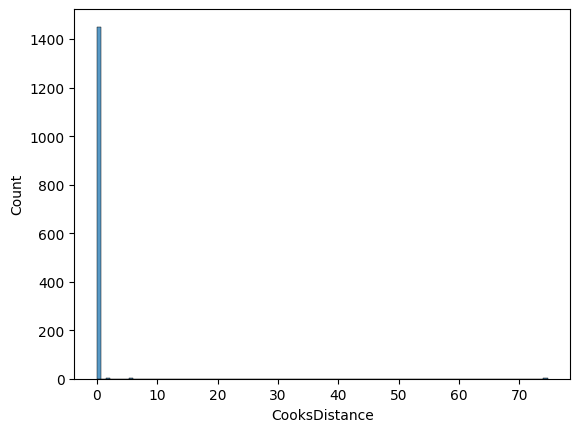

In [23]:
sns.histplot(data=x_cook, x='CooksDistance', bins=100)

Here (https://towardsdatascience.com/are-you-using-feature-distributions-to-detect-outliers-48e2ae3309) it has been said that "any value higher than 4/n, where n is the sample size (1460 in this example), is interesting to investigate. Another way is to calculate the mean µ of the Cook’s distances, and remove values that are greater than 3*µ".  
Let's take 2nd approach to follow and calculate necessary values

In [24]:
mu_cook = x_cook['CooksDistance'].mean()
print("Mean value of Cook's distance is: {:.4f}\nThreshold value: {:.4f}".format(mu_cook, 3*mu_cook))

Mean value of Cook's distance is: 0.0574
Threshold value: 0.1722


In [25]:
x_cook[x_cook['CooksDistance'] > 3*mu_cook]

,const,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial,CooksDistance
523,1.0,0.373288,0.181327,0.666667,1.0,1.000000,0.500,0.47625,1.000000,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.325745
1298,1.0,1.000000,0.292538,0.000000,1.0,1.000000,0.500,0.49750,1.000000,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,74.714628
1321,1.0,0.133562,0.024899,0.666667,1.0,0.222222,0.625,0.00000,0.333333,0.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.313040
1370,1.0,0.236301,0.019164,1.000000,1.0,0.333333,0.625,0.00000,0.000000,0.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.681079


In [26]:
# organizing Cook's distance detection into function
def explore_cook_dist(x, y, calc_cooks=True, display_results=True):
    """
    Analyzes dataset on outliers presense by applying Cook's distance metric 
    to statsmodels.api.OLS model
    Input:
        x - dataset (pandas.DataFrame format) containing regressors only, will fill NaN values with 0
        y - 1-column dataset (pd.Series) containing target
        calc_cooks
    """
    x_cook = sma.add_constant(x)
    model = sma.OLS(y.to_numpy(), x_cook).fit() 

    if calc_cooks:
        #np.set_printoptions(suppress=True)
        influence = model.get_influence()
        cooks = influence.cooks_distance
        x_cook['CooksDistance'] = cooks[0]
        if display_results:
            plt.figure(figsize=(9,5))
            plt.scatter(x.index, cooks[0], s=10)
            plt.xlabel('Id')
            plt.ylabel('Cook\'s Distance')
            #plt.show()
    
    x_cook['prediction'] = model.predict(sma.add_constant(x))
    RMSE = np.sqrt(mean_squared_error(y, x_cook['prediction']))
    r2 = r2_score(y, x_cook['prediction'])

    print(f'RMSE: {RMSE:.0f}')
    print(f'r2: {r2:.4f}')

    if calc_cooks and display_results:
        y.name = 'ground_truth'
        print(pd.concat([x_cook.iloc[:, 1:], y], axis=1).sort_values(by='CooksDistance', ascending=False).head(10))
    return model, x_cook.iloc[:, 1:]

RMSE: 23988
r2: 0.9088
      LotFrontage   LotArea  LotShape  LandSlope  OverallQual  OverallCond  \
1298     1.000000  0.292538  0.000000        1.0     1.000000        0.500   
1321     0.133562  0.024899  0.666667        1.0     0.222222        0.625   
1370     0.236301  0.019164  1.000000        1.0     0.333333        0.625   
523      0.373288  0.181327  0.666667        1.0     1.000000        0.500   
1182     0.476027  0.066947  0.666667        1.0     1.000000        0.500   
691      0.284247  0.094580  0.666667        1.0     1.000000        0.625   
197      0.523973  0.112735  1.000000        1.0     0.777778        0.375   
588      0.150685  0.111220  0.666667        0.0     0.444444        0.875   
1044     0.202055  0.038795  1.000000        1.0     0.777778        0.500   
185      0.236301  0.101194  0.333333        1.0     1.000000        1.000   

      MasVnrArea  ExterQual  ExterCond  BsmtQual  ...  SaleType_Oth  \
1298     0.49750   1.000000       0.50       1.

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x26ef32f1030>,
       LotFrontage   LotArea  LotShape  LandSlope  OverallQual  OverallCond  \
 0        0.150685  0.033420  1.000000        1.0     0.666667        0.500   
 1        0.202055  0.038795  1.000000        1.0     0.555556        0.875   
 2        0.160959  0.046507  0.666667        1.0     0.666667        0.500   
 3        0.133562  0.038561  0.666667        1.0     0.666667        0.500   
 4        0.215753  0.060576  0.666667        1.0     0.777778        0.500   
 ...           ...       ...       ...        ...          ...          ...   
 1455     0.140411  0.030929  1.000000        1.0     0.555556        0.500   
 1456     0.219178  0.055505  1.000000        1.0     0.555556        0.625   
 1457     0.154110  0.036187  1.000000        1.0     0.666667        1.000   
 1458     0.160959  0.039342  1.000000        1.0     0.444444        0.625   
 1459     0.184932  0.040370  1.000000        1.0

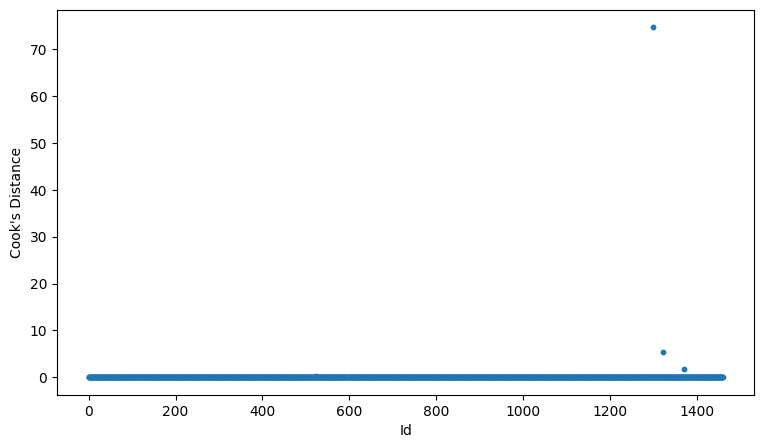

In [27]:
explore_cook_dist(x, y)

### 2.2. DBSCAN

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [29]:
nn_distance_estimator = NearestNeighbors(n_neighbors=1)
nn_res = nn_distance_estimator.fit(x)

In [30]:
distances, indices = nn_res.kneighbors()
print(distances)
print(indices)

[[0.13065397]
 [2.62525879]
 [0.57050053]
 ...
 [3.22249339]
 [2.2147308 ]
 [1.88574666]]
[[1240]
 [ 672]
 [1447]
 ...
 [ 407]
 [1261]
 [ 674]]


In [31]:
neighbors = pd.DataFrame(np.c_[indices,distances], columns=['index', 'distance'])
neighbors.head()

,index,distance
0,1240.0,0.130654
1,672.0,2.625259
2,1447.0,0.570501
3,1174.0,2.570557
4,1417.0,1.540528


In [32]:
x.head()

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,0.150685,0.033420,1.000000,1.0,0.666667,0.500,0.12250,0.666667,0.5,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.202055,0.038795,1.000000,1.0,0.555556,0.875,0.00000,0.333333,0.5,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.160959,0.046507,0.666667,1.0,0.666667,0.500,0.10125,0.666667,0.5,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.133562,0.038561,0.666667,1.0,0.666667,0.500,0.00000,0.333333,0.5,0.6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.215753,0.060576,0.666667,1.0,0.777778,0.500,0.21875,0.666667,0.5,0.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
nn_distance_estimator2 = NearestNeighbors(n_neighbors=2)
nn_res2 = nn_distance_estimator2.fit(x)
dist2, idxs2 = nn_res2.kneighbors()
print(dist2)
print(idxs2)

[[0.13065397 0.72667033]
 [2.62525879 2.68355651]
 [0.57050053 0.67257618]
 ...
 [3.22249339 3.22477946]
 [2.2147308  2.33402551]
 [1.88574666 2.0073275 ]]
[[1240  871]
 [ 672 1259]
 [1447  732]
 ...
 [ 407 1075]
 [1261 1094]
 [ 674 1204]]


Text(0, 0.5, 'Distance')

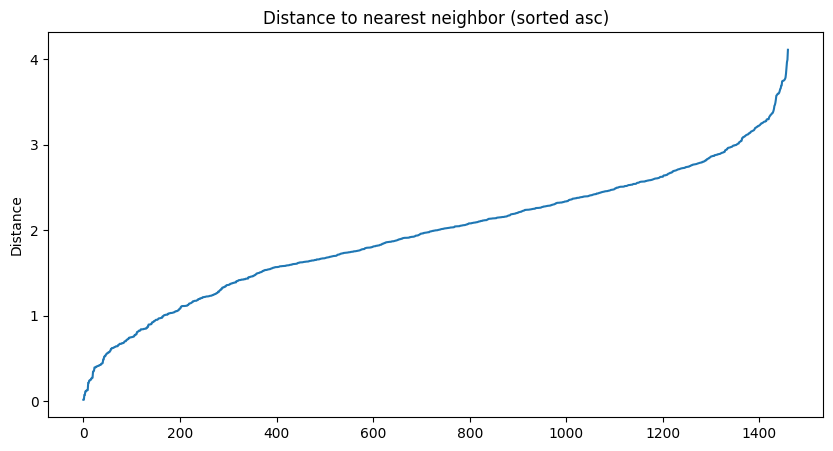

In [34]:
x_dist_sorted = neighbors.sort_values('distance', ascending=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range(len(x_dist_sorted)), x_dist_sorted['distance'])
ax.set_title('Distance to nearest neighbor (sorted asc)')
ax.set_ylabel('Distance')

In [ ]:
"""
# Unfinished function to plot chart as above (sorted distance to nearest neighbor)
def plot_k_distance_graph(df):
    nn = NearestNeighbors(n_neighbors=2)
    nbrs = nn.fit(df)
    distances, _ = nbrs.kneighbors(df)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.figure(figsize=(12,6))
    plt.plot(distances)
    plt.title('K-distance graph',fontsize=20)
    plt.xlabel('Data points sorted by distance',fontsize=14)
    plt.ylabel('Epsilon',fontsize=14)
    plt.show()
"""

In [35]:
dbscan = DBSCAN(eps=3.5, min_samples=201).fit(x)
print(dbscan.labels_)
x['clustered'] = np.where(dbscan.labels_ == -1, 0, 1)
x.head()

[0 0 0 ... 0 0 0]


,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial,clustered
0,0.150685,0.033420,1.000000,1.0,0.666667,0.500,0.12250,0.666667,0.5,0.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,0.202055,0.038795,1.000000,1.0,0.555556,0.875,0.00000,0.333333,0.5,0.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,0.160959,0.046507,0.666667,1.0,0.666667,0.500,0.10125,0.666667,0.5,0.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0.133562,0.038561,0.666667,1.0,0.666667,0.500,0.00000,0.333333,0.5,0.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.215753,0.060576,0.666667,1.0,0.777778,0.500,0.21875,0.666667,0.5,0.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [36]:
print('Number of unclustered elements (outliers): {}'.format(len(x[x['clustered'] == 0])))

Number of unclustered elements (outliers): 157


<AxesSubplot: xlabel='LotArea', ylabel='ground_truth'>

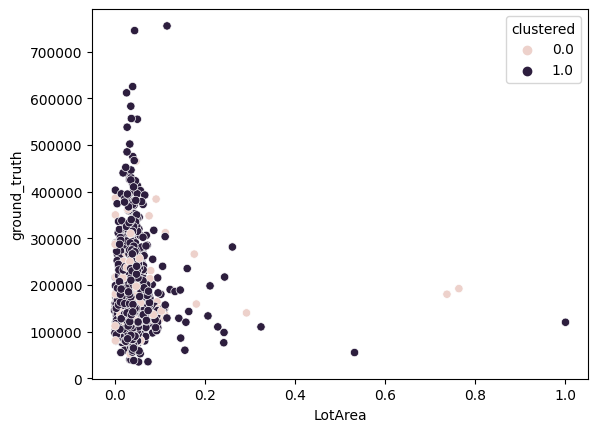

In [37]:
sns.scatterplot(data=pd.concat([x, y], axis=1), x='LotArea', y='ground_truth', hue='clustered')

In [ ]:
"""
# Unfinished function to perform DBSCAN clusterization (1 cluster with 'ordinal' points and the rest are 'outliers')
def run_dbscan(x, y, eps=8000, min_samples=6, scaled=''):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    print(dbscan)

    dbs = dbscan.fit(x)
    clusters = dbs.labels_
    x[f'cluster{scaled}'] = clusters
    x[f'no_cluster{scaled}'] = np.where(x[f'cluster{scaled}'] == -1, 1, 0)

    print(len(x[x[f'cluster{scaled}'] == -1]))
    print(x[f'cluster{scaled}'].unique())
    return x
"""

### 2.3. Isolation Forest

In [38]:
from sklearn.ensemble import IsolationForest

In [39]:
isolation_f = IsolationForest(n_estimators=200, max_features=2, contamination=0.02, random_state=42).fit(x)
res = isolation_f.predict(x)
print(res)

[1 1 1 ... 1 1 1]


In [40]:
x_iso_forest = x.copy()
x_iso_forest['outlier'] = np.where(res == -1, True, False)
print(len(x_iso_forest[x_iso_forest['outlier'] == True]))
print(np.where(res == -1, 1, 0).sum())

30
30


<AxesSubplot: xlabel='LotArea', ylabel='ground_truth'>

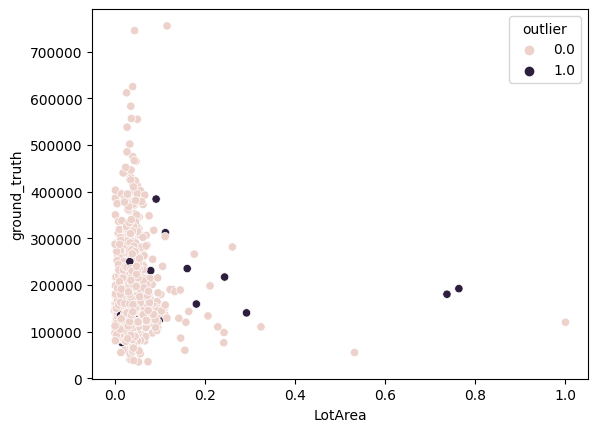

In [41]:
sns.scatterplot(data=pd.concat([x_iso_forest, y], axis=1), x='LotArea', y='ground_truth', hue='outlier')

In [ ]:
"""
# Unfinished function for ouliers detection using IsolationForest
def run_isolation_forest(df, data, contamination=0.025, max_features=2):
    isof = IsolationForest(random_state=30, contamination=contamination, max_features=max_features).fit(df)
    results = isof.predict(df)
    data['isolation scores'] = results
    data['outlier'] = np.where(data[f'isolation scores'] == -1, 1, 0)

    print(len(data[data['isolation scores'] == -1]))
    print(data[f'isolation scores'].unique())

    return data

data = run_isolation_forest(pd.DataFrame(df_scaled, columns=[cols+['SalePrice']]), data)
plot_outliers(data, cols, target_col='SalePrice', outlier_col='outlier')
"""

## 3. Reducing features num

### 3.1. Low variance features detection

In [19]:
from sklearn.feature_selection import VarianceThreshold

In [21]:
thresh = 0.9
sel_vt = VarianceThreshold(threshold=thresh)
try:
    sel_vt.fit(df)
    features_to_use = pd.Series(sel_vt.get_support(), index=df.columns, name='use_feature')
    columns_left = features_to_use[features_to_use == True].index.to_list()
    col_idxs = [df.columns.to_list().index(i) for i in columns_left]
    print('Columns left:', columns_left)
except ValueError:
    print('No feature meets the variance threshold {:.4f}'.format(thresh))

Columns left: ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', 'MiscVal', 'AgeBuilt', 'AgeRemodeled', 'DaysSinceSold']


In [22]:
len(columns_left)

30

### 3.2. Sequential Feature Selection

In [102]:
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
# Try to launch and see how many time it will take
estimator = SVR(kernel='linear')
sel_sfs = SequentialFeatureSelector(estimator, n_features_to_select=150, direction="backward").fit(x, y)

### 3.3. Using Recursive Feature Elimination (RFE) with SVR(kernel='linear') estimator

In [33]:
# 1st run on full df after 'data_clean_prepare.ipynb' (without extra cleaning): Baseline score = 1704784061.0427 +/- 681991515.8835
# Data have to be scaled
#estimator = LinearSVR()
estimator = SVR(kernel='linear') #' , C=100, gamma="auto"
estimator.fit(df, y)
cv_res = cross_val_score(estimator, X, y, cv=5, scoring='neg_mean_squared_error')
print('Baseline score = {:.4f} +/- {:.4f}'.format(-np.mean(cv_res), np.std(cv_res)))

Baseline score = 1704784061.0427 +/- 681991515.8835


In [36]:
# (!) processing duration 109 mins => 84 features left (on full df after 'data_clean_prepare.ipynb' (without extra cleaning))
rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=5, #StratifiedKFold(n_splits=5),
    scoring='neg_mean_squared_error',
    min_features_to_select=1,
)
rfecv.fit(X, y)

features_left = rfecv.get_feature_names_out(input_features=df.columns)
df_reduced = pd.DataFrame(rfecv.transform(df), index=df.index, columns=features_left)

df_reduced.to_csv('datasets/processed/train_reduced_rfecv(svr)_as_df.csv')

RFECV(cv=5, estimator=SVR(kernel='linear'), scoring='neg_mean_squared_error')

In [49]:
cv_res_opt = cross_val_score(estimator, df_reduced, y, cv=5, scoring='neg_mean_squared_error')
print('Score after features reducing = {:.4f} +/- {:.4f}'.format(-np.mean(cv_res_opt), np.std(cv_res_opt)))

Score after features reducing = 1736841976.7689 +/- 597786999.5685


In [ ]:
feat_left_idxs = [list(df.columns).index(x) for x in features_left]

### 3.4. Using f_regression and mutual_info_regression

In [18]:
f_regression(X=df['1stFlrSF'].to_numpy().reshape(-1, 1), y=y) # returns f-statistic and p-value

(array([845.52448774]), array([5.39471062e-147]))

### 3.5. Using Boruta package

In [18]:
import boruta
from sklearn.ensemble import RandomForestRegressor

In [19]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestRegressor(n_jobs=3, max_depth=5)

# define Boruta feature selection method
feat_selector = boruta.BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

In [20]:
# find all relevant features - 5 features should be selected
feat_selector.fit(df.to_numpy(), np.log(y).to_numpy())

# check selected features - first 5 features are selected
#print('Features sorted by importance: ', feat_selector.support_)

# check ranking of features
#print('Features ranking: ', feat_selector.ranking_)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	242
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	242
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	242
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	242
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	242
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	242
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	242
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	16
Rejected: 	206
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	16
Rejected: 	206
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	16
Rejected: 	206
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	16
Rejected: 	206
Iteration: 	12 / 100
Confirmed: 	21
Tentative: 	15
Rejected: 	206
Iteration: 	13 / 100
Confirmed: 	21
Tentative: 	15
Rejected: 	206
Iteration: 	14 / 100
Confirmed: 	21
Tentative: 	14
Rejected: 	207
Iteration: 	15 / 100
Confirmed: 	21
Tentative: 	14
Rejected: 	207
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=164,
                                         n_jobs=3,
                                         random_state=RandomState(MT19937) at 0x26412162640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x26412162640, verbose=2)

In [21]:
df.columns[feat_selector.support_]

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtQual', 'BsmtFinType1', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual',
       'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'AgeBuilt', 'AgeRemodeled', 'AgeGarage',
       'MSZoning_C (all)', 'MSZoning_RM', 'CentralAir_N', 'CentralAir_Y',
       'GarageType_Attchd', 'GarageType_Detchd'],
      dtype='object')

In [22]:
df.columns[feat_selector.support_weak_]

Index(['KitchenAbvGr', 'MSSubClass_30'], dtype='object')

In [28]:
# getting all properties of the object (if not sure how to write property name correctly)
from pprint import pprint

pprint(feat_selector.__dict__)

{'alpha': 0.05,
 'estimator': RandomForestRegressor(max_depth=5, n_estimators=135, n_jobs=3,
                      random_state=RandomState(MT19937) at 0x26572746340),
 'max_iter': 100,
 'n_estimators': 'auto',
 'n_features_': 20,
 'perc': 100,
 'random_state': RandomState(MT19937) at 0x26572746340,
 'ranking_': array([  1,   1,   8,  28,   1,   7,   1,   2,  54,   1,  57,   5,  10,
         1,  83,  45,   9,   1,  54,   1,   1,  71,   1,  25,  34,   1,
        27,  14,  15,   1,   1,  48,  12,   1,   1,   1,   1,  17,  46,
         3,   5,  68,  62,  13,  26,  78, 148, 148, 148,  43,   1,   1,
        24, 103,  82, 148, 148,  52, 148, 148, 148, 148, 148, 148,  93,
        42, 148,  67,  17,  51,  73,  99, 148,  71,  20,  66,  77,  60,
        39, 148,  19,  90, 110, 148, 110, 148, 148,  52, 105, 148,  31,
        11, 106,  84,  37,  15,  58,  79,  75,  35,  33, 148, 148, 148,
       148, 148, 108,  87,  79,  35,  23, 107,  92, 110, 113,  91,  22,
       148,  29, 104,  49, 148, 113, 1

In [37]:
df.loc[:, feat_selector.support_ + feat_selector.support_weak_].to_csv('datasets/processed/train_sel_feat_boruta.csv')

Converting test dataset to Boruta selected

In [27]:
df_test = pd.read_csv('datasets/processed/test_floats_as_df.csv', index_col=0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Columns: 242 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(242)
memory usage: 2.7 MB


In [38]:
test_columns = df.columns[feat_selector.support_ + feat_selector.support_weak_]
print('Columns number:', len(test_columns))
test_columns

Columns number: 31


Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtQual', 'BsmtFinType1', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'KitchenAbvGr',
       'KitchenQual', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'AgeBuilt', 'AgeRemodeled', 'AgeGarage',
       'MSSubClass_30', 'MSZoning_C (all)', 'MSZoning_RM', 'CentralAir_N',
       'CentralAir_Y', 'GarageType_Attchd', 'GarageType_Detchd'],
      dtype='object')

In [39]:
df_test.loc[:, test_columns].to_csv('datasets/processed/test_sel_feat_boruta.csv')

## Getting train and test sets prepared

In [4]:
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2, random_state=42)
print('X train size:', X_train.shape, '\ty train size:', y_train.shape)
print('X val size:', X_val.shape, '\ty val size:', y_val.shape)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X train size: (1168, 242) 	y train size: (1168,)
X val size: (292, 242) 	y val size: (292,)


In [ ]:
Xr_train, Xr_val, yr_train, yr_val = train_test_split(df_reduced, y, test_size)

## Baseline scores

### Using ExtraTreesRegressor

In [6]:
baseline_forest_reg = ExtraTreesRegressor()

In [7]:
baseline_forest_reg.fit(X_train, y_train)

ExtraTreesRegressor()

Baseline score:

In [8]:
print('Baseline (full set of features) train score: {:.4f}'.format(mean_squared_log_error(y_train, baseline_forest_reg.predict(X_train))))
print('Baseline (full set of features) test score: {:.4f}'.format(mean_squared_log_error(y_val, baseline_forest_reg.predict(X_val))))

Baseline (full set of features) train score: 0.0000
Baseline (full set of features) test score: 0.0220


### Using ElasticNet

In [9]:
baseline_elnet_reg = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [10]:
baseline_elnet_reg.fit(X_train_scaled, y_train)

ElasticNet()

In [11]:
print('Baseline (full set of features) train score: {:.4f}'.format(mean_squared_log_error(y_train, baseline_elnet_reg.predict(X_train_scaled))))
print('Baseline (full set of features) test score: {:.4f}'.format(mean_squared_log_error(y_val, baseline_elnet_reg.predict(X_val_scaled))))

Baseline (full set of features) train score: 0.0499
Baseline (full set of features) test score: 0.0660


## Filtering features

### Using features importances from ExtraTreesRegressor

In [32]:
forest_reg = ExtraTreesRegressor()

In [34]:
selector = SelectFromModel(forest_reg, prefit=False, max_features=100, threshold=-np.inf) # To only select based on max_features, set threshold=-np.inf ('mean' is default)
selector.fit(df, y) # if prefit=False

SelectFromModel(estimator=ExtraTreesRegressor(), max_features=100,
                threshold=-inf)

In [35]:
features_to_use = pd.Series(selector.get_support(), index=df.columns, name='use_feature')
features_to_use.info()

<class 'pandas.core.series.Series'>
Index: 242 entries, LotFrontage to SaleCondition_Partial
Series name: use_feature
Non-Null Count  Dtype
--------------  -----
242 non-null    bool 
dtypes: bool(1)
memory usage: 10.2+ KB


In [39]:
columns_left = features_to_use[features_to_use == True].index.to_list()

In [ ]:
col_idxs = [df.columns.to_list().index(x) for x in columns_left]

#### Scoring by ExtraTreesRegressor

In [51]:
forest_reg_reduced = ExtraTreesRegressor()

In [52]:
forest_reg_reduced.fit(X_train[columns_left], y_train)

ExtraTreesRegressor()

In [54]:
print('Train score on reduced features (100 left): {:.4f}'.format(mean_squared_log_error(y_train, forest_reg_reduced.predict(X_train[columns_left]))))
print('Test score on reduced features (100 left): {:.4f}'.format(mean_squared_log_error(y_test, forest_reg_reduced.predict(X_test[columns_left]))))

Train score on reduced features (100 left): 0.0000
Test score on reduced features (100 left): 0.0214


#### Scoring by ElasticNet

In [68]:
elnet_reg_reduced = ElasticNet(alpha=1.0, l1_ratio=0.5)
elnet_reg_reduced.fit(X_train_scaled[:, col_idxs], y_train)

ElasticNet()

In [69]:
print('ElasticNet: Train score on reduced features (100 left): {:.4f}'.format(mean_squared_log_error(y_train, elnet_reg_reduced.predict(X_train_scaled[:, col_idxs]))))
print('ElasticNet: Test score on reduced features (100 left): {:.4f}'.format(mean_squared_log_error(y_test, elnet_reg_reduced.predict(X_test_scaled[:, col_idxs]))))

ElasticNet: Train score on reduced features (100 left): 0.0512
ElasticNet: Test score on reduced features (100 left): 0.0675


#### Scoring by ExtraTreeRegressor

In [76]:
forest_reg_reduced = ExtraTreesRegressor()
forest_reg_reduced.fit(X_train[columns_left], y_train)
print('Train score on reduced features ({} left): {:.4f}'.format(len(columns_left), mean_squared_log_error(y_train, forest_reg_reduced.predict(X_train[columns_left]))))
print('Test score on reduced features ({} left): {:.4f}'.format(len(columns_left), mean_squared_log_error(y_test, forest_reg_reduced.predict(X_test[columns_left]))))

Train score on reduced features (35 left): 0.0000
Test score on reduced features (35 left): 0.0235


#### Scoring by ElasticNet

In [77]:
elnet_reg_reduced = ElasticNet(alpha=1.0, l1_ratio=0.5)
elnet_reg_reduced.fit(X_train_scaled[:, col_idxs], y_train)
print('ElasticNet: Train score on reduced features ({} left): {:.4f}'.format(len(columns_left), mean_squared_log_error(y_train, elnet_reg_reduced.predict(X_train_scaled[:, col_idxs]))))
print('ElasticNet: Test score on reduced features ({} left): {:.4f}'.format(len(columns_left), mean_squared_log_error(y_test, elnet_reg_reduced.predict(X_test_scaled[:, col_idxs]))))

ElasticNet: Train score on reduced features (35 left): 0.0855
ElasticNet: Test score on reduced features (35 left): 0.1123
